<a href="https://colab.research.google.com/github/JericCantos/DisasterTweetPredictions/blob/main/notebooks/DisasterTweetPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Load Libraries

In [62]:
!pip install ftfy

In [63]:
import requests
import io
from ftfy import fix_text

import numpy as np
import pandas as pd
import random
import nltk
import re

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer # more appropriate for tweets than word_tokenizer
from nltk.corpus import wordnet

# Downloading necessary NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')  # List of common stop words in English
nltk.download('punkt')  # Pre-trained tokenizer models
nltk.download('wordnet')  # WordNet lemmatizer dataset
nltk.download('omw-1.4') # Open Multilingual Wordnet to improve WordNet dataset
nltk.download('averaged_perceptron_tagger')  # Needed for POS tagging
nltk.download('averaged_perceptron_tagger_eng') # Needed for POS tagging

# Libraries for text feature extraction and model training
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Libraries for model evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import KFold, cross_val_score

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


## Load Dataset

In [64]:
# Build the direct download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))
    # Decode as UTF-8 manually, not using response.text
    #decoded_content = response.content.decode('utf-8', errors='replace')
    #return pd.read_csv(io.StringIO(decoded_content))

In [65]:
file_ids = {
    "train": "1a8kB3M_-ZTQFJemnNY_g9M3d6yIoJERL",
}

# train: https://drive.google.com/file/d/1a8kB3M_-ZTQFJemnNY_g9M3d6yIoJERL/view?usp=drive_link

In [66]:
df_train = load_csv_from_url(make_drive_url(file_ids["train"]))

### Fix Double Encoding Errors

In [67]:
# Fix encoding of all tweets to avoid words like "America\x89Ûªs"
df_train['text'] = df_train['text'].apply(fix_text)

In [68]:
def fix_double_encoding(text):
    try:
        return text.encode('latin1').decode('utf-8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        return text


In [69]:
df_train['text'] = df_train['text'].apply(lambda t: fix_double_encoding(fix_text(t)))

In [70]:
def repair_text(s):
    if not isinstance(s, str):
        return s
    try:
        # step 1: encode the visible garbage characters as if they were latin1 bytes
        # step 2: decode them back as UTF-8
        s_fixed = s.encode('cp1252', errors='ignore').decode('utf-8', errors='ignore')
        return s_fixed
    except Exception:
        return s


In [71]:
df_train['text'] = df_train['text'].apply(repair_text)

In [72]:
df_train.head(20)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1
8,There's an emergency evacuation happening now ...,1
9,I'm afraid that the tornado is coming to our a...,1


# Data Preprocessing

In [73]:
# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

In [74]:
def fix_encoding(text):
    try:
        # Encode as latin1 and decode as utf-8 to reverse mojibake
        return text.encode('latin1').decode('utf-8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        # If it fails, return original
        return text

In [75]:
# Define the preprocessing function
def preprocess_text(sentences):
    # Fix encoding of all tweets to avoid words like "America\x89Ûªs"
    sentences = [fix_encoding(sentence) for sentence in sentences]

    # Convert all tokens to lowercase
    sentences = [sentence.lower() for sentence in sentences]

    # Replace Unicode full-width @ with normal @
    sentences = [re.sub(r"＠", "@", sentence) for sentence in sentences]


    # Remove punctuation using regex
    # Keep hashtags and mentions
    sentences = [re.sub(r"[^\w\s'#@]", "", sentence) for sentence in sentences]

    # Remove numbers and URLs starting with http or www
    sentences = [re.sub(r"http\S+|www\S+|\d+", "", sentence)
                  for sentence in sentences]


    # Remove extra whitespace between words
    sentences = [" ".join(sentence.split()) for sentence in sentences]

    # Tokenize sentences into words
    tokenizer = TweetTokenizer(preserve_case=False)
    sentences = [tokenizer.tokenize(sentence) for sentence in sentences]

    # Remove stop words and single-letter wordsd
    stop_words = set(stopwords.words('english'))  # Load English stop words
    filtered_sentences = []
    for sentence in sentences:
        filtered_sentence = [word for word in sentence if
                             word not in stop_words and
                             len(word) > 1]
        filtered_sentences.append(filtered_sentence)


    lemmatized_sentences = []
    lemmatizer = WordNetLemmatizer()
    for sentence in filtered_sentences:
      # Get POS tags for each word
      pos_tags = nltk.pos_tag(sentence)

      # Lemmatize with POS tags
      lemmas = []
      for word, tag in pos_tags:
        wn_pos = get_wordnet_pos(tag)
        lemmas.append(lemmatizer.lemmatize(word, pos=wn_pos))
      lemmatized_sentences.append(lemmas)

    return [' '.join(sentence) for sentence in lemmatized_sentences]

In [76]:
# shuffle the training ddata
df_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

df_shuffled.head(20)

,text,target
0,So you have a new weapon that can cause un-ima...,1
1,The f$&@ing things I do for #GISHWHES Just got...,0
2,DT @georgegalloway: RT @Galloway4Mayor: The Co...,1
3,Aftershock back to school kick off was great. ...,0
4,in response to trauma Children of Addicts deve...,0
5,@Calum5SOS you look like you got caught in a r...,0
6,my favorite lady came to our volunteer meeting...,1
7,@brianroemmele UX fail of EMV - people want to...,1
8,Can't find my ariana grande shirt this is a f...,0
9,The Murderous Story Of America۪s First Hijacki...,1


In [77]:
tweets = df_shuffled['text']
targets = df_shuffled['target']

pre_processed_tweets = pd.Series(preprocess_text(tweets))

In [78]:
pre_processed_tweets.head(20)

,0
0,new weapon cause unimaginable destruction
1,@ing thing #gishwhes get soaked deluge go pad ...
2,dt @georgegalloway rt @gallowaymayor col polic...
3,aftershock back school kick great want thank e...
4,response trauma child addict develop defensive...
5,@calumsos look like get catch rainstorm amaze ...
6,favorite lady come volunteer meet hopefully jo...
7,@brianroemmele ux fail emv people want insert ...
8,can't find ariana grande shirt fuck tragedy
9,murderous story america first hijack


In [79]:
pre_processed_tweets.iloc[9]

'murderous story america first hijack'

In [80]:
tweets.iloc[9]

'The Murderous Story Of America۪s First Hijacking http://t.co/EYUGk6byxr'

# Train-Test Split

In [81]:
df = pd.DataFrame({'text': pre_processed_tweets, 'target': targets})
df.head()

,text,target
0,new weapon cause unimaginable destruction,1
1,@ing thing #gishwhes get soaked deluge go pad ...,0
2,dt @georgegalloway rt @gallowaymayor col polic...,1
3,aftershock back school kick great want thank e...,0
4,response trauma child addict develop defensive...,0


In [82]:
df['target'].value_counts(normalize=True)

,proportion
target,
0,0.57034
1,0.42966


There is a slight imbalance in the dataset (~57% negative, ~43% positive). Stratification is a good idea.

In [83]:
# Use train_test_split instead so we can stratify the split to maintain balance
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['target'],
                                                    test_size=0.2,
                                                    stratify=df['target'],
                                                    random_state=42)

# Print sizes of training and test sets
print("Size of training set:", len(X_train))
print("Size of test set:", len(X_test))

Size of training set: 6090
Size of test set: 1523


# Feature Extraction

In [84]:
# Use a tweet tokenizer in the TfidVectorizer so it becomes
# aware of mentions and hashtags
tweet_tokenizer = TweetTokenizer(preserve_case=False)

tfidf_vectorizer = TfidfVectorizer(
    tokenizer = tweet_tokenizer.tokenize,
    preprocessor = None,
    token_pattern = None
)

# Transform the training data into a TF-IDF matrix
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# Transform the test data into a TF-IDF matrix
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# Check the number of samples and features
num_samples, num_features = X_train_tfidf.shape
print("Train #Samples: {}, #Features: {}".format(num_samples, num_features))
num_samples_test, num_features_test = X_test_tfidf.shape
print("Test #Samples: {}, #Features: {}".format(num_samples_test,
                                                num_features_test))

Train #Samples: 6090, #Features: 13656
Test #Samples: 1523, #Features: 13656


In [85]:
tfidf_vectorizer.get_feature_names_out()

array(['##book', '##fukushima', '##youtube', ..., 'zss', 'zumiez', 'zzzz'],
      dtype=object)

# Machine Learning Setup

Given the imbalance in the dataset, I would choose F1 score as the ultimate metric for evaluation. However, I will train versions of various models optimizing for f1, f1-weighted, and roc-auc to see which one will give the best F1 score.

## Global Configuration Values

In [86]:
# Dictionary of Results
model_comparisons = {}

scoring_functions = ['f1', 'f1_weighted', 'roc_auc']

## Helper Functions

In [87]:
def create_pipeline(model):
  return Pipeline([
    ('tfidf', TfidfVectorizer(
        tokenizer = tweet_tokenizer.tokenize,
        preprocessor = None,
        token_pattern = None
    )),
    ('model', model)
  ])

In [88]:
def get_param_grid(model):
    # Return an appropriate parameter grid for GridSearchCV,
    # based on the model type.

    # Shared TF-IDF hyperparameters
    base_grid = {
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
        'tfidf__max_df': [0.8, 1.0], # ignore too common words
        'tfidf__min_df': [1, 2], # ignore too rare words
    }

    # Model-specific hyperparameters
    if isinstance(model, RandomForestClassifier):
        model_grid = {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        }

    elif isinstance(model, LogisticRegression):
        model_grid = {
            'model__C': [0.1, 1, 10],
            'model__solver': ['saga'],
            #'model__penalty': ['l2', 'l1'],  # saga supports both
            'model__max_iter': [100, 200]
        }

    elif isinstance(model, MultinomialNB):
        model_grid = {
            'model__alpha': [0.1, 0.5, 1.0],
            'model__fit_prior': [True, False]
        }

    else:
        raise ValueError(f"Model type {type(model).__name__} not supported.")

    # Merge shared TF-IDF + model-specific parameters
    full_grid = {**base_grid, **model_grid}

    return full_grid

In [89]:
def train_model(pipeline, X_train_scaled, y_train,
                X_test_scaled, y_test,
                param_grid, ispca, n_components, scoring, cv=5,
                              numeric_features=  ['applicant_income',
                                          'coapplicant_income',
                                          'loan_amount' ]):

  if(ispca):
    print ('Components:', i)
    pca = PCA(n_components=n_components,
                         random_state=42)
    X_train_scaled = pca.fit_transform(X_train_scaled)
    X_test_scaled = pca.transform(X_test_scaled)

  # Set up the GridSearchCV
  grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv,
                            scoring=scoring, n_jobs=-1, verbose=1)

  # Fit the grid search model
  grid_search.fit(X_train_scaled, y_train)

  # Best parameters found by Grid Search
  print("Best Hyperparameters:", grid_search.best_params_)

  return (grid_search.best_estimator_,
          X_train_scaled,
          X_test_scaled,
          y_train,
          y_test,
          grid_search.best_params_,
          )

In [106]:
def evaluate_model (model, X_train, y_train, X_test, y_test, best_params,
                    run_label):
  print(f'-----{run_label}-----')

  train_pred = model.predict(X_train)
  y_pred = model.predict(X_test)

  # evaluate train
  train_accuracy = round(accuracy_score(y_train, train_pred)*100, 2)
  train_conf_matrix = confusion_matrix(y_train, train_pred)
  train_class_report = classification_report(y_train, train_pred)
  train_roc_auc = round(roc_auc_score(y_train, train_pred)*100, 2)
  train_f1 = round(f1_score(y_train, train_pred)*100, 2)
  train_f1_weighted = round(f1_score(y_train, train_pred, average='weighted')*100, 2)

  # evaluate test
  accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
  conf_matrix = confusion_matrix(y_test, y_pred)
  class_report = classification_report(y_test, y_pred)
  roc_auc = round(roc_auc_score(y_test, y_pred)*100, 2)
  f1 = round(f1_score(y_test, y_pred)*100, 2)
  f1_weighted = round(f1_score(y_test, y_pred, average='weighted')*100, 2)

  # Printing evaluation metrics
  print("Training Confusion Matrix:\n", train_conf_matrix)
  print("Testing Confusion Matrix:\n", conf_matrix)
  print("Accuracy: Test", accuracy, ' - ' , train_accuracy, 'Train')
  print("ROC AUC: Test", roc_auc, ' - ' , train_roc_auc, 'Train')
  print("F1-score: Test", f1, ' - ' , train_f1, 'Train')
  print("Weighted F1-score:", f1_weighted, ' - ' , train_f1_weighted, 'Train')

  print("Training Classification Report:\n", train_class_report)
  print("Test Classification Report:\n", class_report)

  #Save the run stats
  model_comparisons[run_label] = {'accuracy': accuracy,
                                  'conf_matrix': conf_matrix,
                                  'class_report': class_report,
                                  'roc_auc' : roc_auc,
                                  'f1' : f1,
                                  'f1_weighted': f1_weighted,
                                  'best_params': best_params,
                                  'model': model}


In [103]:
def model_summaries (model_list):
  df_models = pd.DataFrame.from_dict(model_comparisons, orient='index')
  df_models = df_models[['f1_weighted', 'roc_auc', 'f1', 'accuracy' ]]
  df_models = df_models.reset_index()
  df_models.rename(columns={'index': 'model'}, inplace=True)


  return df_models[df_models['model'].isin(model_list)]\
              .sort_values(by='f1', ascending=False)

# Logistic Regression

Logistic regression
optimized for F1 Score with the following hyperparameters resulted in the best F1-score among the tested variants:

```
Best Hyperparameters: {
    'model__C': 10,
    'model__max_iter': 100,
    'model__solver': 'saga',
    'tfidf__max_df': 0.8,
    'tfidf__min_df': 1,
    'tfidf__ngram_range': (1, 3)
    }
```

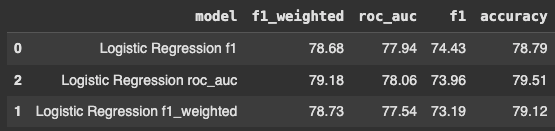

In [92]:
'''
Scoring Function: f1
Best Hyperparameters: {
    'model__C': 10,
    'model__max_iter': 100,
    'model__solver': 'saga',
    'tfidf__max_df': 0.8,
    'tfidf__min_df': 1,
    'tfidf__ngram_range': (1, 3)
    }
'''

for scoring in scoring_functions:
  my_X_train = X_train
  my_X_test = X_test
  my_y_train = y_train
  my_y_test = y_test

  model = LogisticRegression(max_iter=10000, random_state=42,)

  param_grid = get_param_grid(model)
  pipeline = create_pipeline(model)
  ispca = False
  n_components = 0

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(pipeline,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, f'Logistic Regression {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters: {'model__C': 10, 'model__max_iter': 100, 'model__solver': 'saga', 'tfidf__max_df': 0.8, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3)}
-----Logistic Regression f1-----
Training Confusion Matrix:
 [[3444   29]
 [  58 2559]]
Testing Confusion Matrix:
 [[730 139]
 [184 470]]
Accuracy: Test 78.79  -  98.57 Train
ROC AUC: Test 77.94  -  98.47 Train
F1-score: 74.43  -  98.33 Train
Weighted F1-score: 78.68  -  98.57 Train
Training Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3473
           1       0.99      0.98      0.98      2617

    accuracy                           0.99      6090
   macro avg       0.99      0.98      0.99      6090
weighted avg       0.99      0.99      0.99      6090

Test Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       

In [104]:
df_summary = model_summaries(['Logistic Regression f1',
                   'Logistic Regression f1_weighted',
                   'Logistic Regression roc_auc'])

df_summary

,model,f1_weighted,roc_auc,f1,accuracy
0,Logistic Regression f1,78.68,77.94,74.43,78.79
2,Logistic Regression roc_auc,79.18,78.06,73.96,79.51
1,Logistic Regression f1_weighted,78.73,77.54,73.19,79.12


# Multinomial Naive Bayes

Optimizing for F1 score again yields the best F1 score on the test dataset among all variants at 76.72. All Multinomial NB models outperformed the best Logistic Regression model.

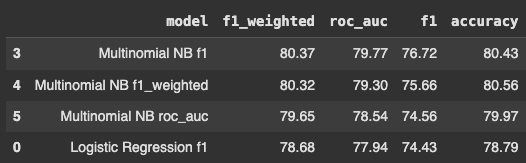

In [94]:
'''
Scoring Function: f1
Best Hyperparameters: {
  'model__alpha': 1.0,
  'model__fit_prior': False,
  'tfidf__max_df': 0.8,
  'tfidf__min_df': 2,
  'tfidf__ngram_range': (1, 1)
}
'''

for scoring in scoring_functions:
  my_X_train = X_train
  my_X_test = X_test
  my_y_train = y_train
  my_y_test = y_test

  model = MultinomialNB()

  param_grid = get_param_grid(model)
  pipeline = create_pipeline(model)
  ispca = False
  n_components = 0

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(pipeline,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, f'Multinomial NB {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters: {'model__alpha': 1.0, 'model__fit_prior': False, 'tfidf__max_df': 0.8, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
-----Multinomial NB f1-----
Training Confusion Matrix:
 [[3147  326]
 [ 476 2141]]
Testing Confusion Matrix:
 [[734 135]
 [163 491]]
Accuracy: Test 80.43  -  86.83 Train
ROC AUC: Test 79.77  -  86.21 Train
F1-score: 76.72  -  84.23 Train
Weighted F1-score: 80.37  -  86.78 Train
Training Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      3473
           1       0.87      0.82      0.84      2617

    accuracy                           0.87      6090
   macro avg       0.87      0.86      0.86      6090
weighted avg       0.87      0.87      0.87      6090

Test Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       869
           1      

In [107]:
df_summary = model_summaries(['Multinomial NB f1',
                   'Multinomial NB f1_weighted',
                   'Multinomial NB roc_auc',
                   'Logistic Regression f1'])

df_summary

,model,f1_weighted,roc_auc,f1,accuracy
3,Multinomial NB f1,80.37,79.77,76.72,80.43
4,Multinomial NB f1_weighted,80.32,79.30,75.66,80.56
5,Multinomial NB roc_auc,79.65,78.54,74.56,79.97
0,Logistic Regression f1,78.68,77.94,74.43,78.79
